# Level Decomposition for a two stage stochastic problem 

In [42]:
import gurobipy as gp;
from gurobipy import GRB;
import numpy as np;
import math;
import matplotlib
import matplotlib.pyplot as plt

Consider the following two stage stochastic problem:

\begin{equation}
\begin{array}{ll}
\displaystyle \min & x_1 + 2x_2 + 2x_3 + x_4 + \mathbb{E}_{\xi}\left[y_1 + 2y_2 + y_3 + 2y_4\right] \\
\mbox{s.t.} & x_1 + x_2 \leq 4 \\
            & \xi_1^kx_1 + x_2 + y_1 \geq 7\\
            & \xi_2^kx_1 + x_2 +y_2 \geq 4\\
            & 0.5\xi_1^kx_1 + x_3 +y_3 \geq 5\\
            & 0.5\xi_2^kx_1 + x_4 +y_4 \geq 8\\
            & x,y \geq 0\\
\end{array}
\end{equation}

given 
\begin{equation}
(\xi_1,\xi_2) = \left\{
\begin{array}{ll}
(1,1/3) & \text{w.p} \; \frac{1}{4} \\
(4,1) & \text{w.p} \; \frac{1}{4} \\
(5/2,2/3) & \text{w.p} \; \frac{1}{4} \\
(1,1) & \text{w.p} \; \frac{1}{4} \\
\end{array}
\right.
\end{equation}

* Subproblem **(optimality)**:
\begin{equation}
\begin{array}{lll}
\displaystyle Q(\hat{x},\xi^k) := \min_{y} & y_1 + 2y_2 + y_3 + 2y_4 \\
\mbox{s.t.}   & \xi_1^k\hat{x}_1 + \hat{x}_2 + y_1 \geq 7 & (\pi^k_1) \\
              & \xi_2^k\hat{x}_1 + \hat{x}_2 + y_2 \geq 4 & (\pi^k_2)\\
              & 0.5xi_1^k\hat{x}_1 + \hat{x}_3 + y_3 \geq 5 & (\pi^k_3)\\
              & 0.5xi_2^k\hat{x}_1 + \xi_1^k\hat{x}_4 + y_4 \geq 4 & (\pi^k_4)\\
              & y\geq 0 \\
\end{array}
\end{equation}

* Master problem **(multi cut)**:

\begin{equation}
\begin{array}{ll}
\displaystyle \min & x_1 + 2x_2 + 2x_3 + x_4 + \sum_{k=1}^4p_k\theta_k \\
\mbox{s.t.}  & x_1 + x_2 \leq 4 \\
& \theta_k \geq  \pi^k_1(7-\xi_1^kx_1-x_2) + \pi^k_2(4-\xi_2^kx_1-x_2) + \pi^k_3(5-0.5\xi_1^kx_1-x_3) + \pi^k_4(8-0.5\xi_2^kx_1-\xi_1^kx_4) & \forall \; \pi^k \in \Pi \\
& x \geq 0 \\
\end{array}
\end{equation}

## Parameters for the problem

In [43]:
xi_comb = [(1,1/3), (4,1), (5/2,2/3), (1,1)]; # all possible scenarios

num_scen = len(xi_comb);

prob_scen = np.ones(num_scen)*1/num_scen; # prob of each scenario

x_coeff = [1, 2, 2, 1]; # coefficients for x variables

y_coeff = [1, 2, 1, 2]; # coefficients for y variables

stab_cntr = np.zeros(num_scen); # stability center at iter=1 for level decomposition

## Define level set problem

In [44]:
LSP = gp.Model("LD Master");

x = {};
for i in range(4):
    x[i] = LSP.addVar(vtype = GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY, name = 'x' + str(i));
    
theta = {};
for i in range(num_scen):
    theta[i] = LSP.addVar(vtype = GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY, name = 'theta' + str(i));
    
C1_LSP = LSP.addConstr(x[0] + x[1] <= 4);

Levelcon_LSP = LSP.addConstr(sum(x_coeff[i]*x[i] for i in range(4)) + sum(prob_scen[i]*theta[i] \
                                                                        for i in range(num_scen)) <= 0); 

# minimize the squared L-2 norm w.r.t. a stability center
LSP.setObjective( 1/2 * sum( (x[i] - stab_cntr[i]) * (x[i] - stab_cntr[i])  for i in range(4)), GRB.MINIMIZE);
    
LSP.setParam("OutputFlag", 0);
LSP.update();

## Define Sub Problem

In [45]:
SP = gp.Model("LD Subproblem");
SP.modelsense = GRB.MINIMIZE;

y = {};
for i in range(4):
    y[i] = SP.addVar(vtype = GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY, obj = y_coeff[i]);

Constr_SP = {};
Constr_SP[0] = SP.addConstr(y[0] >= 0); #rhs to be updated later
Constr_SP[1] = SP.addConstr(y[1] >= 0); #rhs to be updated later
Constr_SP[2] = SP.addConstr(y[2] >= 0); #rhs to be updated later
Constr_SP[3] = SP.addConstr(y[3] >= 0); #rhs to be updated later

SP.setParam("OutputFlag", 0);
SP.setParam("InfUnbdInfo", 1);

SP.update()

## Level Decomposition with: 
1. $\lambda = 0.2929$,
2. Intial stability center = $(0,0,0,0)$, and 
3. Stability center at iter i, $z^i = x_i$ (current iterate solution)

In [46]:
F_Low = 0;
F_up = 36;
F_lev = 0;
F_Low_list = [];
F_up_list = []
iter = 0;
lmbda = 0.2929; # optimal value of lambda for convergence

while (F_up-F_Low)*1/F_up > 1e-5:
    
    iter += 1;    
    print('\n*******************************Iteration', iter, '*******************************')
      
    F_lev = F_Low + lmbda*(F_up - F_Low);
    Levelcon_LSP.setAttr(GRB.Attr.RHS, F_lev); 
    
    LSP.optimize();
    
    while LSP.status != 2:
        F_Low = F_lev;
        F_lev = F_Low + lmbda*(F_up - F_Low);
        Levelcon_LSP.setAttr(GRB.Attr.RHS, F_lev);
        LSP.optimize();
        
    print('F_Low: ', F_Low);
    F_Low_list.append(F_Low);
           
    xval = np.zeros(4);
    for i in range(4):
        xval[i] = x[i].x;

    theta_val = np.zeros(num_scen);   
    for i in range(num_scen):
        theta_val[i] = theta[i].x;
        
    stab_cntr = xval;    
    LSP.setObjective(1/2 * sum( (x[i] - stab_cntr[i]) * (x[i] - stab_cntr[i]) for i in range(4)), GRB.MINIMIZE);   
    LSP.update()
 
    duals = np.zeros(num_scen, dtype = np.ndarray);
    SP_objval = np.zeros(num_scen);

    teLSP_F_up = 0;

    for i in range(num_scen):
        Constr_SP[0].setAttr(GRB.Attr.RHS, 7 - xi_comb[i][0]*xval[0] - xval[1]);
        Constr_SP[1].setAttr(GRB.Attr.RHS, 4 - xi_comb[i][1]*xval[0] - xval[1]);
        Constr_SP[2].setAttr(GRB.Attr.RHS, 5 - 0.5*xi_comb[i][0]*xval[0] - xval[2]);
        Constr_SP[3].setAttr(GRB.Attr.RHS, 8 - 0.5*xi_comb[i][1]*xval[0] - xi_comb[i][0]*xval[3]);

        SP.update();
        SP.optimize();

        SP_objval[i] = SP.objVal;
        duals[i] = [Constr_SP[0].pi, Constr_SP[1].pi, Constr_SP[2].pi, Constr_SP[3].pi];

    teLSP_F_up = sum(xval[i] * x_coeff[i] for i in range(4)) + sum(prob_scen[i] * SP_objval[i] 
                                                                          for i in range(num_scen));              
    if teLSP_F_up < F_up:
        F_up = teLSP_F_up;

    print('F_Up: ', F_up);
    F_up_list.append(F_up);
    
    if (F_up-F_Low)*1/F_up < 1e-5:
        break;
        
    else:
        scenr_count = 0;

        for i in range(num_scen): 
            if theta_val[i] < SP_objval[i] - 1e-5: 
            
                ocut_rhs = 7*duals[i][0] + 4*duals[i][1] + 5*duals[i][2] +  8*duals[i][3];

                LSP.addConstr(theta[i] + duals[i][0] * (xi_comb[i][0]*x[0] + x[1]) \
                                + duals[i][1] * (xi_comb[i][1]*x[0] + x[1]) \
                                + duals[i][2] * (0.5*xi_comb[i][0]*x[0] + x[2]) \
                                + duals[i][3] * (0.5*xi_comb[i][1]*x[0] + xi_comb[i][0]*x[3]) >= ocut_rhs);

                print('Added Optimality Cut for Scenario ',scenr_count, ': theta', str(i), '+ ',
                      (duals[i][0]*xi_comb[i][0] + duals[i][1]*xi_comb[i][1] + duals[i][2]*0.5*xi_comb[i][0] 
                       + duals[i][3]*0.5*xi_comb[i][1]), 'x1 + ' ,duals[i][0] + duals[i][1], 'x2 + ' , 
                      duals[i][2], 'x3 + ', duals[i][3]*xi_comb[i][0], 'x4 >= ', ocut_rhs);

            scenr_count += 1;
            
    print('Added constraint for projection of current iterate on level set: ')       
    print( x_coeff[0], 'x1 + ', x_coeff[1], 'x2 + ',x_coeff[2], 'x3 + ',x_coeff[3], 'x4 + ', prob_scen[0], 'theta_1 + ', 
        prob_scen[1], 'theta_2 + ', prob_scen[2], 'theta_3 + ', prob_scen[3], 'theta_4 <= ', F_lev);
    
    print('\nx1 = %f, x2 = %f, x3 = %f, x4 = %f' % (xval[0], xval[1], xval[2], xval[3]));
    
print('\n\t\t<<<<Model converged within the required gap.>>>>')

print('\nx1 = %f, x2 = %f, x3 = %f, x4 = %f, Best Objective = %f, Total iterations = %d' \
      % (xval[0], xval[1], xval[2], xval[3], F_Low, iter));


*******************************Iteration 1 *******************************
F_Low:  0
F_Up:  36
Added Optimality Cut for Scenario  0 : theta 0 +  2.5 x1 +  3.0 x2 +  1.0 x3 +  2.0 x4 >=  36.0
Added Optimality Cut for Scenario  1 : theta 1 +  9.0 x1 +  3.0 x2 +  1.0 x3 +  8.0 x4 >=  36.0
Added Optimality Cut for Scenario  2 : theta 2 +  5.75 x1 +  3.0 x2 +  1.0 x3 +  5.0 x4 >=  36.0
Added Optimality Cut for Scenario  3 : theta 3 +  4.5 x1 +  3.0 x2 +  1.0 x3 +  2.0 x4 >=  36.0
Added constraint for projection of current iterate on level set: 
1 x1 +  2 x2 +  2 x3 +  1 x4 +  0.25 theta_1 +  0.25 theta_2 +  0.25 theta_3 +  0.25 theta_4 <=  10.5444

x1 = 0.000000, x2 = 0.000000, x3 = 0.000000, x4 = 0.000000

*******************************Iteration 2 *******************************
F_Low:  10.5444
F_Up:  18.546494756688624
Added Optimality Cut for Scenario  1 : theta 1 +  2.0 x1 +  2.0 x2 +  0.0 x3 +  0.0 x4 >=  8.0
Added Optimality Cut for Scenario  2 : theta 2 +  3.2499999999999996 x1 +  

## Convergence of level decomposition

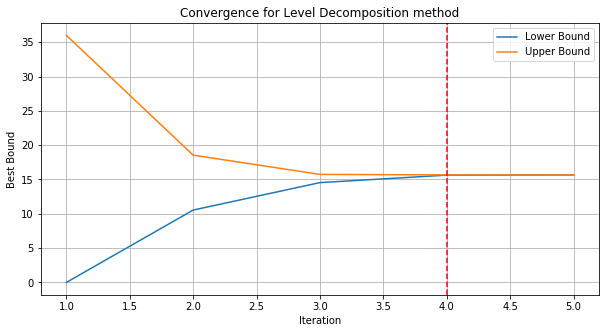

In [47]:
fig, ax = plt.subplots(figsize=(10,5));

ax.plot([i for i in range(1,iter+1)], F_Low_list, label = 'Lower Bound');
ax.plot([i for i in range(1,iter+1)], F_up_list, label = 'Upper Bound');

ax.set(xlabel='Iteration', ylabel='Best Bound',
       title='Convergence for Level Decomposition method')
ax.grid()
ax.axvline(x=4, color = 'r', ls = '--')
ax.legend()
plt.show()

## Level Decomposition with: 
1. $\lambda = 0.2929$,
2. Intial stability center = $(3.99,0,0,2.69)$, and 
3. Stability center at iter i, $z^i = x_i$ (current iterate solution)

In [48]:
stab_cntr = [3.99, 0, 0, 2.69]; #good initial solution (iteration 4 solution)

In [49]:
F_Low = 0;
F_up = 36;
F_lev = 0;
F_Low_list = [];
F_up_list = []
iter = 0;
lmbda = 0.2929; # optimal value of lambda for convergence

while (F_up-F_Low)*1/F_up > 1e-5:
    
    iter += 1;    
    print('\n*******************************Iteration', iter, '*******************************')
      
    F_lev = F_Low + lmbda*(F_up - F_Low);
    Levelcon_LSP.setAttr(GRB.Attr.RHS, F_lev); 
    
    LSP.optimize();
    
    while LSP.status != 2:
        F_Low = F_lev;
        F_lev = F_Low + lmbda*(F_up - F_Low);
        Levelcon_LSP.setAttr(GRB.Attr.RHS, F_lev);
        LSP.optimize();
        
    print('F_Low: ', F_Low);
    F_Low_list.append(F_Low);
           
    xval = np.zeros(4);
    for i in range(4):
        xval[i] = x[i].x;

    theta_val = np.zeros(num_scen);   
    for i in range(num_scen):
        theta_val[i] = theta[i].x;
        
    stab_cntr = xval;    
    LSP.setObjective(1/2 * sum( (x[i] - stab_cntr[i]) * (x[i] - stab_cntr[i]) for i in range(4)), GRB.MINIMIZE);   
    LSP.update()
 
    duals = np.zeros(num_scen, dtype = np.ndarray);
    SP_objval = np.zeros(num_scen);

    teLSP_F_up = 0;

    for i in range(num_scen):
        Constr_SP[0].setAttr(GRB.Attr.RHS, 7 - xi_comb[i][0]*xval[0] - xval[1]);
        Constr_SP[1].setAttr(GRB.Attr.RHS, 4 - xi_comb[i][1]*xval[0] - xval[1]);
        Constr_SP[2].setAttr(GRB.Attr.RHS, 5 - 0.5*xi_comb[i][0]*xval[0] - xval[2]);
        Constr_SP[3].setAttr(GRB.Attr.RHS, 8 - 0.5*xi_comb[i][1]*xval[0] - xi_comb[i][0]*xval[3]);

        SP.update();
        SP.optimize();

        SP_objval[i] = SP.objVal;
        duals[i] = [Constr_SP[0].pi, Constr_SP[1].pi, Constr_SP[2].pi, Constr_SP[3].pi];

    teLSP_F_up = sum(xval[i] * x_coeff[i] for i in range(4)) + sum(prob_scen[i] * SP_objval[i] 
                                                                          for i in range(num_scen));              
    if teLSP_F_up < F_up:
        F_up = teLSP_F_up;

    print('F_Up: ', F_up);
    F_up_list.append(F_up);
    
    if (F_up-F_Low)*1/F_up < 1e-5:
        break;
        
    else:
        scenr_count = 0;

        for i in range(num_scen): 
            if theta_val[i] < SP_objval[i] - 1e-5: 
            
                ocut_rhs = 7*duals[i][0] + 4*duals[i][1] + 5*duals[i][2] +  8*duals[i][3];

                LSP.addConstr(theta[i] + duals[i][0] * (xi_comb[i][0]*x[0] + x[1]) \
                                + duals[i][1] * (xi_comb[i][1]*x[0] + x[1]) \
                                + duals[i][2] * (0.5*xi_comb[i][0]*x[0] + x[2]) \
                                + duals[i][3] * (0.5*xi_comb[i][1]*x[0] + xi_comb[i][0]*x[3]) >= ocut_rhs);

                print('Added Optimality Cut for Scenario ',scenr_count, ': theta', str(i), '+ ',
                      (duals[i][0]*xi_comb[i][0] + duals[i][1]*xi_comb[i][1] + duals[i][2]*0.5*xi_comb[i][0] 
                       + duals[i][3]*0.5*xi_comb[i][1]), 'x1 + ' ,duals[i][0] + duals[i][1], 'x2 + ' , 
                      duals[i][2], 'x3 + ', duals[i][3]*xi_comb[i][0], 'x4 >= ', ocut_rhs);

            scenr_count += 1;
            
    print('Added constraint for projection of current iterate on level set: ')       
    print( x_coeff[0], 'x1 + ', x_coeff[1], 'x2 + ',x_coeff[2], 'x3 + ',x_coeff[3], 'x4 + ', prob_scen[0], 'theta_1 + ', 
        prob_scen[1], 'theta_2 + ', prob_scen[2], 'theta_3 + ', prob_scen[3], 'theta_4 <= ', F_lev);
    
    print('\nx1 = %f, x2 = %f, x3 = %f, x4 = %f' % (xval[0], xval[1], xval[2], xval[3]));
    
print('\n\t\t<<<<Model converged within the required gap.>>>>')

print('\nx1 = %f, x2 = %f, x3 = %f, x4 = %f, Best Objective = %f, Total iterations = %d' \
      % (xval[0], xval[1], xval[2], xval[3], F_Low, iter));


*******************************Iteration 1 *******************************
F_Low:  10.5444
F_Up:  15.667172982193948
Added constraint for projection of current iterate on level set: 
1 x1 +  2 x2 +  2 x3 +  1 x4 +  0.25 theta_1 +  0.25 theta_2 +  0.25 theta_3 +  0.25 theta_4 <=  18.00034524

x1 = 3.999809, x2 = 0.000107, x3 = 0.000158, x4 = 2.693063

*******************************Iteration 2 *******************************
F_Low:  15.666547799599103
F_Up:  15.666698723080689

		<<<<Model converged within the required gap.>>>>

x1 = 3.999985, x2 = 0.000010, x3 = 0.000007, x4 = 2.693065, Best Objective = 15.666548, Total iterations = 2


## Convergence for good initial solution

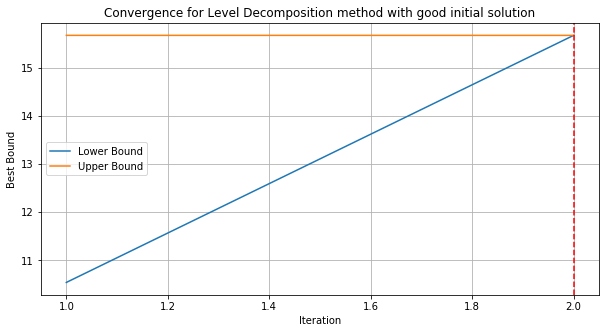

In [50]:
fig, ax = plt.subplots(figsize=(10,5));

ax.plot([i for i in range(1,iter+1)], F_Low_list, label = 'Lower Bound');
ax.plot([i for i in range(1,iter+1)], F_up_list, label = 'Upper Bound');

ax.set(xlabel='Iteration', ylabel='Best Bound',
       title='Convergence for Level Decomposition method with good initial solution')
ax.grid()
ax.axvline(x=2, color = 'r', ls = '--')
ax.legend()
plt.show()